前面提到过RNN等模型的缺点是需要顺序计算，从而很难并行。因此出现了Extended Neural GPU、ByteNet和ConvS2S等网络模型。这些模型都是以CNN为基础，这比较容易并行。但是和RNN相比，它较难学习到长距离的依赖关系。

本文的Transformer使用了Self-Attention机制，它在编码每一词的时候都能够注意(attend to)整个句子，从而可以解决长距离依赖的问题，同时计算Self-Attention可以用矩阵乘法一次计算所有的时刻，因此可以充分利用计算资源(CPU/GPU上的矩阵运算都是充分优化和高度并行的)。

In [21]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many 
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        # encoder和decoder都是构造的时候传入的，这样会非常灵活
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        # generator就是根据decoder的hidden state输出当前时刻的词
        # 基本实现就是hidden state输入一个ful-connect layer,ful-connect layer的输出大小就是词的个数
        # 然后接一个softmax变成概率
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask,
                            tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

EncoderDecoder定义了一种通用的Encoder-Decoder架构，具体的Encoder、Decoder、src_embed、target_embed和generator都是构造函数传入的参数。这样我们做实验更换不同的组件就会更加方便。

In [22]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    # 根据 Decoder的hidden state输出一个词
    # d_model:Decoder输出的大小, vocab:词典大小
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

### Encoder

In [23]:
def clones(module, N):
    "Produce N identical SubLayers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [24]:
class Encoder(nn.Module):
    "Core encoder is a stack of N EncoderLayer"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        # layer是一个SubLayer
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [25]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

Encoder使input sequence$(x_1, ..., x_n)$编码成一个连续的序列$z=(z_1,...,z_n)$

注意:Layer Normalization不是Batch Normalization.如所示，原始论文模型为:   

`x -> attention(x) -> x+self-attention(x) -> layernorm(x+self-attention(x)) -> y -> dense(y) -> y+dense(y)`    
`-> layernorm(y+dense(y)) -> z(输入下一层)`

这里稍微做一下修改，在self-attention和dense之后加了一个dropout层。另外一个不通就是把layernorm层放到前面了。这里的模型为：

`x -> layernorm(x) -> attention(layernorm(x)) -> x + attention(layernorm(x)) -> y -> layernorm(y) ->`          
`dense(layernorm(y)) -> y+dense(laynorm(y))`

原始论文的layernorm放在最后；而这里把它放在最前面并且在Encoder的最后一层再加了一个layernorm。这里的实现和论文的实现基本是一致的，只是给最底层的输入x多做了一个layernorm，而原始论文是没有的。下面是Encoder的forward方法，这样对比读者可能会比较清楚为什么N个EncoderLayer处理完成之后还需要一个LayerNorm

不管是Self-Attention还是全连接层，都首先是LayerNorm，然后是Self-Attention/Dense，然后是Dropout，最好是残差连接。这里面有很多可以重用的代码，我们把它封装成SublayerConnection。

In [26]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

这个类会构造LayerNorm和Dropout，但是Self-Attention或者Dense并不在这里构造，还是放在了EncoderLayer里，在forward的时候由EncoderLayer传入。这样的好处是更加通用，比如Decoder也是类似的需要在Self-Attention、Attention或者Dense前面后加上LayerNorm和Dropout以及残差连接，我们就可以复用代码。但是这里要求传入的sublayer可以使用一个参数来调用的函数(或者有__call__)。

In [27]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

为了复用，这里的self_attn层和feed_forward层也是传入的参数，这里只构造两个SublayerConnection。forward调用sublayer\[0\](这是SublayerConnection对象)的__call__方法，最终会调到它的forward方法，而这个方法需要两个参数，一个是输入Tensor,一个是callable,并且这个callable可以用一个参数来调用。而self_attn函数需要4个参数(Query的输入，Key的输入，Value的输入和Mask),因此这里我们使用lambda的技巧把它变成一个参数x的函数(mask可以看成已知的数)。因为lambda的形参也叫x，读者可能难以理解，我们改写一下：

In [28]:
def forward(self, x, mask):
    z = lambda y: self.self_attn(y, y, y, mask)
    x = self.sublayer[0](x, z)
    return self.sublayer[1](x, self.feed_forward)

self_attn有4个参数，但是我们知道在Encoder里，前三个参数都是输入y，第四个参数是mask。这里mask是已知的，因此我们可以用lambda的技巧它变成一个参数的函数`z = lambda y: self.self_attn(y, y, y, mask)`，这个函数的输入是y。

self.sublayer\[0\]是个callable，`self.sublayer[0](x, z)`会调用`self.sublayer[0].call(x, z)`，然后会调用`SublayerConnection.forward(x, z)`，然后会调用`sublayer(self.norm(x))`，`sublayer`就是传入的参数`z`，因此就是`z(self.norm(x))`。z是一个lambda，我们可以先简单的看成一个函数，显然这里要求函数z的输入是一个参数。理解了Encoder之后，Decoder就很简单了。

### Decoder

The decoder is also composed of a stack of $N=6$ identical layers.

In [2]:
import torch
import torch.nn as nn

In [3]:
class Decoder(nn.Module):
    "Generic(通用的) N layer decoder with masking"
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask) # Encoder层输出memory, src_mask:输入Encoder的Mask,tgt_mask:输入Decoder的Mask
        return self.nrom(x)

Decoder也是N个DecoderLayer的stack，参数layer是DecoderLayer，它也是一个callable，最终__call__会调用`DecoderLayer.forward`方法，这个方法(后面会介绍)需要4个参数，输入x，Encoder层的输出memory，输入Encoder的Mask(src_mask)和输入Decoder的Mask(tgt_mask)。所有这里的Decoder的forward也需要这4个参数。

In [4]:
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (define below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

DecoderLayer比EncoderLayer多了一个src-attn层，这是Decoder时attend to Encoder的输出(memory)。src-attn和self-attn的实现是一样的，只不过使用的Query，Key和Value的输入不同。普通的Attention(src-attn)的Query是下层输入进来的(来自self-attn的输出)，Key和Value是Encoder最后一层的输出memory；而Self-Attention的Query，Key和Value都是来自下层输入进来的。

Decoder和Encoder有一个关键的不同：Decoder在解码第$t$个时刻的时候只能使用$1,...,t$时刻的输入，而不能使用$t+1$时刻及其之后的输入。因此我们需要一个函数来产生一个Mask矩阵，代码如下：

In [5]:
def subsequent_mask(size):
    "Mask out(掩盖) subsequent position"
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

In [7]:
# np.triu():返回上三角矩阵
import numpy as np
attn_shape = (1, 5, 5)
subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
subsequent_mask

array([[[0, 1, 1, 1, 1],
        [0, 0, 1, 1, 1],
        [0, 0, 0, 1, 1],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0]]], dtype=uint8)

In [8]:
torch.from_numpy(subsequent_mask) == 0

tensor([[[ True, False, False, False, False],
         [ True,  True, False, False, False],
         [ True,  True,  True, False, False],
         [ True,  True,  True,  True, False],
         [ True,  True,  True,  True,  True]]])

### Attention

An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors. The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility(兼容性) function of the query with the corresponding key.

We call our particular attention “Scaled Dot-Product Attention”. The input consists of queries and keys of dimension $d_k$, and values of dimension $d_v$. We compute the dot products of the query with all keys, divide each by $\sqrt{d_k}$, and apply a softmax function to obtain the weights on the values.

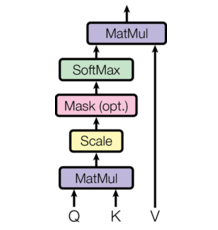

In practice, we compute the attention function on a set of queries simultaneously, packed together into a matrix $Q$. The keys and values are also packed together into matrices $K$ and $V$. We compute the matrix of outputs as:
$$Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_k}})V$$

[masked_fill() and masked_fill_()](http://localhost:8889/lab/tree/mask.ipynb) 

#### Attention中的Mask

在 Attention 机制中，同样需要忽略 padding 部分的影响，这里以transformer encoder中的self-attention为例：

self-attention中，Q和K在点积之后，需要先经过mask再进行softmax，因此，对于要屏蔽的部分，mask之后的输出需要为负无穷，这样softmax之后输出才为0。

In [9]:
import math

def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.mask_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

我们使用一个实际的例子跟踪一些不同Tensor的shape,然后对照公式就很容易理解。比如

The two most commonly used attention functions are additive attention, and dot-product (multiplicative) attention. Dot-product attention is identical to our algorithm, except for the scaling factor of $\frac{1}{\sqrt{d_k}}$. Additive attention computes the compatibility function using a feed-forward network with a single hidden layer. While the two are similar in theoretical complexity, dot-product attention is much faster and more space-efficient in practice, since it can be implemented using highly optimized matrix multiplication code.

While for small values of $d_k$ the two mechanisms perform similarly, additive attention outperforms dot product attention without scaling for larger values of $d_k$. We suspect that for large values of $d_k$, the dot products grow large in magnitude, pushing the softmax function into regions where it has extremely small gradients (To illustrate why the dot products get large, assume that the components of $q$ and $k$ are independent variables with mean 0 and variance 1. Then their dot product, $q\cdot h=\sum_{i=1}^{d_k}q_i k_i$, has mean 0 and variance $d_k$). To counteract this effect, we scale the dot products by $\frac{1}{\sqrt{d_k}}$

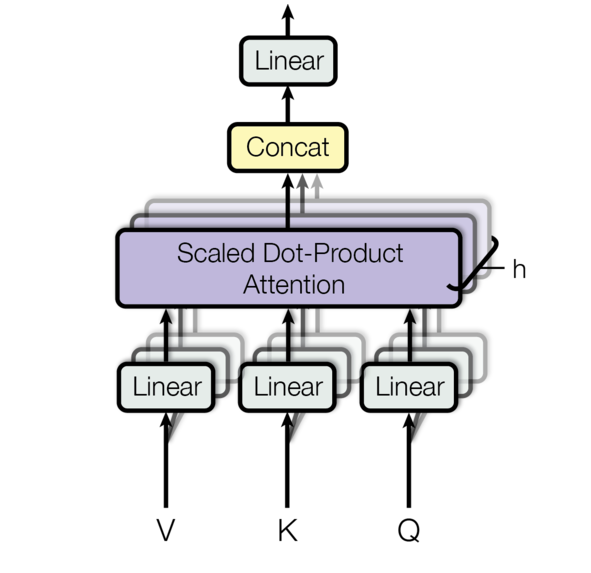

Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions. With a single attention head, averaging inhibits(抑制) this.

$$MultiHead(Q, K, V)=Concat(head_1,...,head_h)W^O$$

where $$head_i = Attention(QW_i^Q, KW)i^K, VW_i^V)$$

where the projections are parameter matrices $W_i^Q \in \mathbb{R}^{d_{model}\times d_k},W_i^K \in \mathbb{R}^{d_{model}\times d_k},W_i^V \in \mathbb{R}^{d_{model}\times d_v}$ and $W^O \in \mathbb{R}^{hd_v \times d_{model}}$. In this work we employ $h=8$ parallel attention layers, or heads. For each of these we use $d_k = d_v = d_{model}/h = 64$. Due to the reduced dimension of each head, the total computational cost is similar to that of single-head attention with full dimensionality.


In [11]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in(吸收) model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # we assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        if mask is not None:
            # Same mask applied to all h heads
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model -> h * d_k
        query, key, value = [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
                             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch.
        x, self.attn = attention(query, key, value, mask=mask,
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

对于上面代码中关于[PyTorch中的contiguous的讲解](http://localhost:8890/lab/tree/contiguous.ipynb)

### Applications of Attention in our Model

The Transformer uses multi-head attention in three different ways: 

1) In “encoder-decoder attention” layers, the queries come from the previous decoder layer, and the memory keys and values come from the output of the encoder. This allows every position in the decoder to attend over all positions in the input sequence. This mimics(模仿) the typical encoder-decoder attention mechanisms in sequence-to-sequence models.

2) The encoder contains self-attention layers. In a self-attention layer all of the keys, values and queries come from the same place, in this case, the output of the previous layer in the encoder. Each position in the encoder can attend to all positions in the previous layer of the encoder.

3) Similarly, self-attention layers in the decoder allow each position in the decoder to attend to all positions in the decoder up to(直到) and including that position. We need to prevent leftward information flow in the decoder to preserve(保存，保留) the auto-regressive property. We implement this inside of scaled dot- product attention by masking out (setting to $-\infty$) all values in the input of the softmax which correspond to illegal connections.

## Position-wise Feed-Forward Networks

In addition to attention sub-layers, each of the layers in our encoder and decoder contains a fully connected feed-forward network, which is applied to each position separately and identically. This consists of two linear transformations with a ReLU activation in between.

$$FFN(x)=max(0, xW_1 + b_1)W_2 + b_2$$

While the linear transformations are the same across different positions, they use different parameters from layer to layer.Another way of describing this is as two convolutions with kernel size 1. The dimensionality of input and output is $d_{model}=512$, and the inner-layer has dimensionality $d_{ff}=2048$.

In [12]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

## Positional Encoding

Since our model contains no recurrence and no convolution, in order for the model to make use of the order of the sequence, we must inject some information about the relative or absolute position of the tokens in the sequence. To this end, we add “positional encodings” to the input embeddings at the bottoms of the encoder and decoder stacks. The positional encodings have the same dimension $d_{model}$ as the embeddings, so that the two can be summed. There are many choices of positional encodings, learned and fixed.

In this work, we use sine and cosine functions of different frequencies: 

$$PE_{(pos, 2i)}=sin(pos/10000^{{2i}/{d_{model}}})$$

$$PE_{(pos, 2i+1)}=cos(pos/10000^{{2i}/{d_{model}}})$$

where $pos$ is the position and $i$ is the dimension. That is, each dimension of positional encoding corresponds to a sinusoid. The wavelengths form a geometric progression from $2\pi$ to $10000 \cdot 2\pi$. We chose this function because we hypothesized it would allow the model to easily learn to attend(参与) by relative position, since for any fixed offset $k$, $PE_{pos+k}$ can be represented as a linear function of $PE_{pos}$.

In addition, we apply dropout to the sums of the embeddings and the positional encodings in both the encoder and decoder stacks. For the base model, we use a rate of $P_{drop}=0.1$.

In [13]:
class PositionalEncoding(nn.Module):
    "Implement the PE function"
    def __init__(self, d_model, dropout, max_len=50000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * 
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)],
                         requires_grad=False)
        return self.dropout(x)

这里值得注意的是调用了Module.register_buffer函数。这个函数的作用是创建一个buffer，比如这里把pi保存下来。register_buffer通常用于保存一些模型参数之外的值，比如在BatchNorm中，我们需要保存running_mean(Moving Average)，它不是模型的参数(不用梯度下降)，但是模型会修改它，而且在预测的时候也要使用它。这里也是类似的，pe是一个提前计算好的常量，我们在forward要用到它。我们在构造函数里并没有把pe保存到self里，但是在forward的时候我们却可以直接使用它(self.pe)。如果我们保存(序列化)模型到磁盘的话，PyTorch框架也会帮我们保存buffer里的数据到磁盘，这样反序列化的时候能恢复它们。

**Below the positional encoding will add in a sine wave based on position. The frequency and offset of the wave is different for each dimension.**

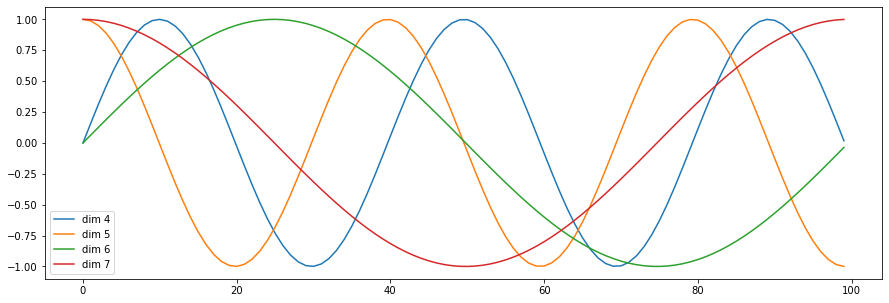

In [15]:
import matplotlib.pyplot as plt
from torch.autograd import Variable

plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])

We also experimented with using learned positional embeddings instead, and found that the two versions produced nearly identical results. We chose the sinusoidal version because it may allow the model to extrapolate(外推) to sequence lengths longer than the ones encountered during training.

## Full Model

**Here we define a function that takes in hyperparameters and produces a full model.**

In [18]:
import copy

def make_model(src_vocab, tgt_vocab, N=6,
               d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))
    
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model    

In [19]:
# Small example model.
tmp_model = make_model(10, 10, 2)

NameError: name 'clones' is not defined

## Training

This section describes the training regime for our models.

**We stop for a quick interlude(插曲) to introduce some of the tools needed to train a standard encoder decoder model. First we define a batch object that holds the src and target sentences for training, as well as constructing the masks.**

## Batches and Masking

In [20]:
class Batch:
    "Object for holding a batch of data with mask during training"
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
        
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create Mask to make us not to attend to the future words"
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

Batch构建函数的输入是src和trg,后者可以为None,因为在预测时是没有tgt的。我们用一个例子来说明Batch的代码，这是训练阶段的一个Batch, src是(48, 20), 48是batch的大小，而20是最长的句子长度，不够长的padding为20。而trg是(48, 25),表示翻译后最长的句子是25个词，不足的也padding。

